# “A Multi-Objective Analysis of Spiking Neuron Models for Neuromorphic AI”

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters (same for all models)
T = 200.0          # total time (ms)
dt = 0.01          # time step (ms)
t = np.arange(0, T, dt)


# Input current parameters
I_const = 50.0     # constant input
I_amp = 5.0        # sinusoidal amplitude
freq = 10.0        # Hz
noise_std = 1.0    # noise strength


In [71]:
def constant_current(I):
    return I * np.ones_like(t)


In [72]:
def sinusoidal_current(I0, A, f):
    return I0 + A * np.sin(2 * np.pi * f * t / 1000)


In [73]:
def noisy_current(I0, noise_std):
    noise = np.random.normal(0, noise_std, size=len(t))
    return I0 + noise


In [74]:
# Choose input type
I_input = constant_current(I_const)
# I_input = sinusoidal_current(I_const, I_amp, freq)
# I_input = noisy_current(I_const, noise_std)


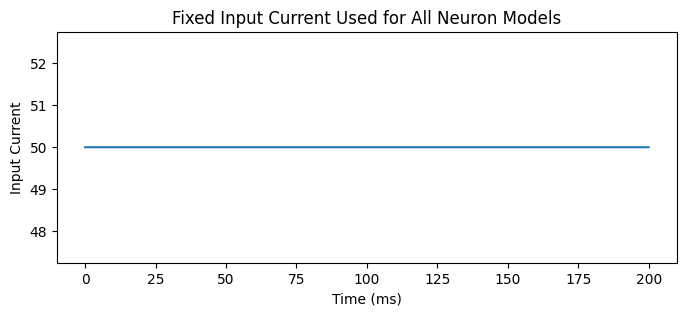

In [75]:
plt.figure(figsize=(8, 3))
plt.plot(t, I_input)
plt.xlabel("Time (ms)")
plt.ylabel("Input Current")
plt.title("Fixed Input Current Used for All Neuron Models")
plt.show()


## LIF Neuron Model

In [76]:
# LIF parameters
V_rest = -65.0      # resting potential (mV)
V_reset = -65.0     # reset potential (mV)
V_th = -30.0        # spike threshold (mV)
tau_m = 20.0        # membrane time constant (ms)
R = 1.0             # membrane resistance


In [77]:
def lif_neuron(I_input):
    V = np.zeros(len(t))
    V[0] = V_rest
    spikes = []

    for i in range(1, len(t)):
        dV = (-(V[i-1] - V_rest) + R * I_input[i-1]) / tau_m
        V[i] = V[i-1] + dt * dV

        if V[i] >= V_th:
            V[i] = V_reset
            spikes.append(t[i])

    return V, np.array(spikes)


In [78]:
V_lif, spikes_lif = lif_neuron(I_input)


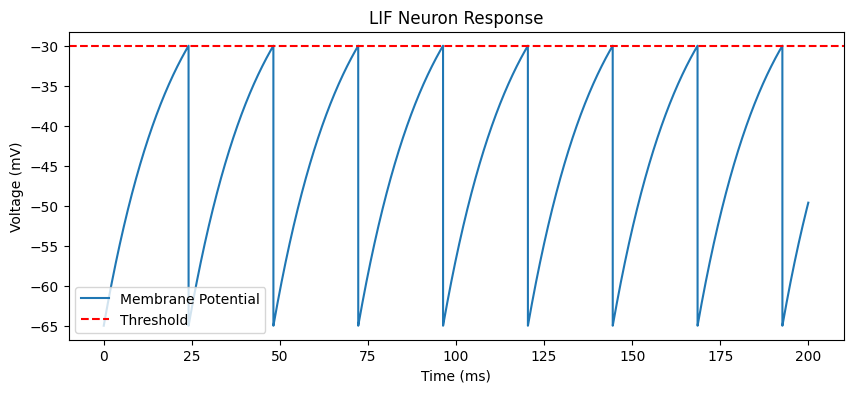

In [79]:
plt.figure(figsize=(10, 4))
plt.plot(t, V_lif, label="Membrane Potential")
plt.axhline(V_th, color='r', linestyle='--', label="Threshold")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.title("LIF Neuron Response")
plt.legend()
plt.show()


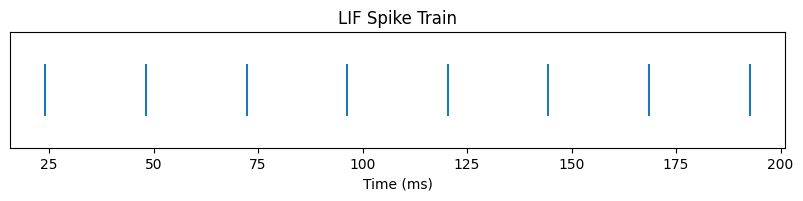

In [80]:
plt.figure(figsize=(10, 1.5))
plt.eventplot(spikes_lif, lineoffsets=1, linelengths=0.8)
plt.xlabel("Time (ms)")
plt.title("LIF Spike Train")
plt.yticks([])
plt.show()


## Izhikevich Neuron Model

In [81]:
# Izhikevich parameters (Regular Spiking)
a = 0.02
b = 0.2
c = -65.0
d = 8.0


In [82]:
def izhikevich_neuron(I_input):
    v = np.zeros(len(t))
    u = np.zeros(len(t))
    v[0] = -65.0
    u[0] = b * v[0]
    spikes = []

    for i in range(1, len(t)):
        dv = 0.04 * v[i-1]**2 + 5 * v[i-1] + 140 - u[i-1] + I_input[i-1]
        du = a * (b * v[i-1] - u[i-1])

        v[i] = v[i-1] + dt * dv
        u[i] = u[i-1] + dt * du

        if v[i] >= 30:
            v[i-1] = 30
            v[i] = c
            u[i] += d
            spikes.append(t[i])

    return v, u, np.array(spikes)


In [83]:
v_izh, u_izh, spikes_izh = izhikevich_neuron(I_input)


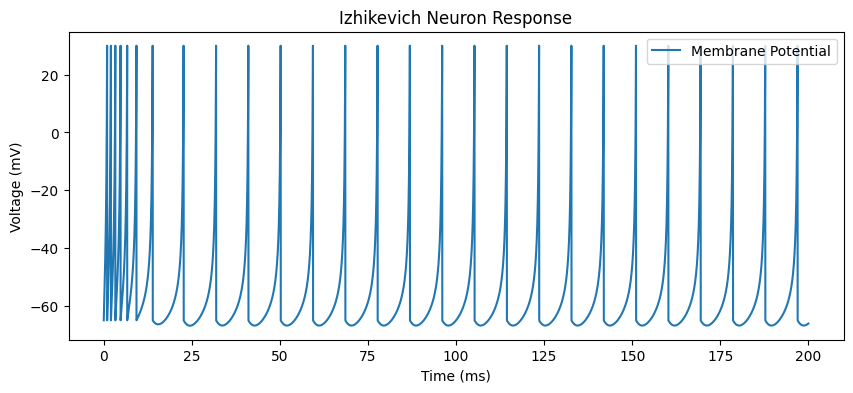

In [84]:
plt.figure(figsize=(10, 4))
plt.plot(t, v_izh, label="Membrane Potential")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.title("Izhikevich Neuron Response")
plt.legend()
plt.show()


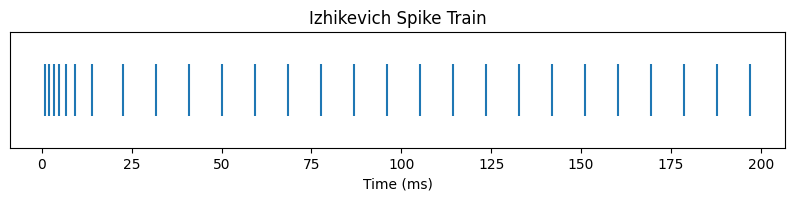

In [85]:
plt.figure(figsize=(10, 1.5))
plt.eventplot(spikes_izh, lineoffsets=1, linelengths=0.8)
plt.xlabel("Time (ms)")
plt.title("Izhikevich Spike Train")
plt.yticks([])
plt.show()


## Hodgkin–Huxley Neuron

In [86]:
# Hodgkin-Huxley parameters
C_m = 1.0      # membrane capacitance (uF/cm^2)

g_Na = 120.0   # sodium conductance
g_K = 36.0     # potassium conductance
g_L = 0.3      # leak conductance

E_Na = 50.0    # sodium reversal (mV)
E_K = -77.0    # potassium reversal (mV)
E_L = -54.4    # leak reversal (mV)


In [87]:
def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1 / (1 + np.exp(-(V + 35) / 10))

def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)


In [88]:
def hodgkin_huxley_neuron(I_input):
    V = np.zeros(len(t))
    m = np.zeros(len(t))
    h = np.zeros(len(t))
    n = np.zeros(len(t))

    V[0] = -65.0
    m[0] = alpha_m(V[0]) / (alpha_m(V[0]) + beta_m(V[0]))
    h[0] = alpha_h(V[0]) / (alpha_h(V[0]) + beta_h(V[0]))
    n[0] = alpha_n(V[0]) / (alpha_n(V[0]) + beta_n(V[0]))

    spikes = []

    for i in range(1, len(t)):
        I_Na = g_Na * m[i-1]**3 * h[i-1] * (V[i-1] - E_Na)
        I_K  = g_K * n[i-1]**4 * (V[i-1] - E_K)
        I_L  = g_L * (V[i-1] - E_L)

        dV = (I_input[i-1] - I_Na - I_K - I_L) / C_m
        V[i] = V[i-1] + dt * dV

        m[i] = m[i-1] + dt * (alpha_m(V[i-1])*(1-m[i-1]) - beta_m(V[i-1])*m[i-1])
        h[i] = h[i-1] + dt * (alpha_h(V[i-1])*(1-h[i-1]) - beta_h(V[i-1])*h[i-1])
        n[i] = n[i-1] + dt * (alpha_n(V[i-1])*(1-n[i-1]) - beta_n(V[i-1])*n[i-1])

        if V[i] > 0 and V[i-1] <= 0:
            spikes.append(t[i])

    return V, m, h, n, np.array(spikes)


In [89]:
V_hh, m_hh, h_hh, n_hh, spikes_hh = hodgkin_huxley_neuron(I_input)


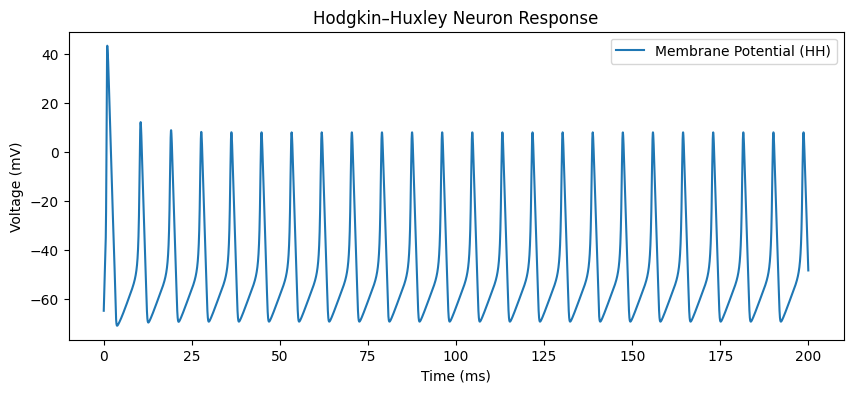

In [90]:
plt.figure(figsize=(10, 4))
plt.plot(t, V_hh, label="Membrane Potential (HH)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.title("Hodgkin–Huxley Neuron Response")
plt.legend()
plt.show()


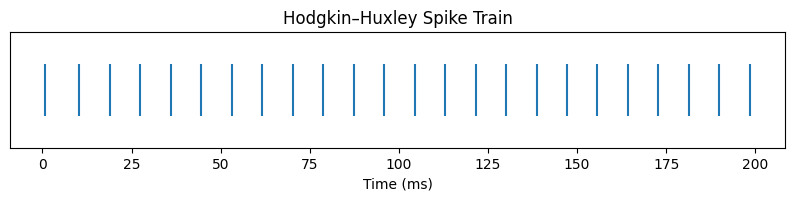

In [91]:
plt.figure(figsize=(10, 1.5))
plt.eventplot(spikes_hh, lineoffsets=1, linelengths=0.8)
plt.xlabel("Time (ms)")
plt.title("Hodgkin–Huxley Spike Train")
plt.yticks([])
plt.show()


Spike Fidelity & Computational Cost Metrics

In [92]:
spikes_lif
spikes_izh
spikes_hh


array([  0.77,  10.25,  18.92,  27.49,  36.04,  44.59,  53.14,  61.68,
        70.23,  78.78,  87.32,  95.87, 104.42, 112.97, 121.51, 130.06,
       138.61, 147.15, 155.7 , 164.25, 172.8 , 181.34, 189.89, 198.44])

In [93]:
def firing_rate(spikes, T):
    return len(spikes) / (T / 1000)  # Hz


In [94]:
fr_lif = firing_rate(spikes_lif, T)
fr_izh = firing_rate(spikes_izh, T)
fr_hh  = firing_rate(spikes_hh, T)


In [95]:
fr_error_lif = abs(fr_lif - fr_hh)
fr_error_izh = abs(fr_izh - fr_hh)


In [96]:
def spike_timing_error(ref_spikes, test_spikes):
    n = min(len(ref_spikes), len(test_spikes))
    if n == 0:
        return np.inf
    return np.mean(np.abs(ref_spikes[:n] - test_spikes[:n]))


In [97]:
timing_err_lif = spike_timing_error(spikes_hh, spikes_lif)
timing_err_izh = spike_timing_error(spikes_hh, spikes_izh)


In [98]:
def isi_variance(spikes):
    if len(spikes) < 2:
        return np.inf
    isi = np.diff(spikes)
    return np.var(isi)


In [99]:
isi_lif = isi_variance(spikes_lif)
isi_izh = isi_variance(spikes_izh)
isi_hh  = isi_variance(spikes_hh)


Runtime Cost

In [100]:
import time as time_module

def runtime_cost(func, I_input, runs=5):
    times = []
    for _ in range(runs):
        start = time_module.time()
        func(I_input)
        times.append(time_module.time() - start)
    return np.mean(times)



In [101]:
time_lif = runtime_cost(lif_neuron, I_input)
time_izh = runtime_cost(izhikevich_neuron, I_input)
time_hh  = runtime_cost(hodgkin_huxley_neuron, I_input)


In [102]:
state_vars = {
    "LIF": 1,
    "Izhikevich": 2,
    "Hodgkin-Huxley": 4
}


In [104]:
models = ["LIF", "Izhikevich", "Hodgkin-Huxley"]

firing_rate_error = np.array([
    fr_error_lif,
    fr_error_izh,
    0.0              # HH reference
])

timing_error = np.array([
    timing_err_lif,
    timing_err_izh,
    0.0
])

runtime = np.array([
    time_lif,
    time_izh,
    time_hh
])


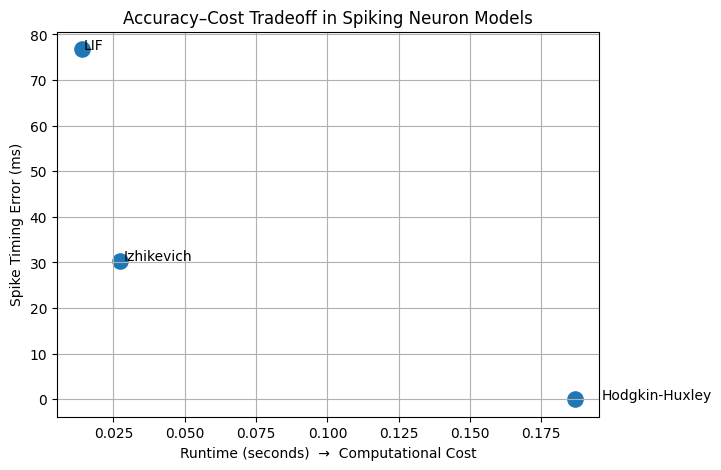

In [105]:
plt.figure(figsize=(7, 5))
plt.scatter(runtime, timing_error, s=120)

for i, model in enumerate(models):
    plt.text(runtime[i]*1.05, timing_error[i], model)

plt.xlabel("Runtime (seconds)  →  Computational Cost")
plt.ylabel("Spike Timing Error (ms)")
plt.title("Accuracy–Cost Tradeoff in Spiking Neuron Models")
plt.grid(True)
plt.show()


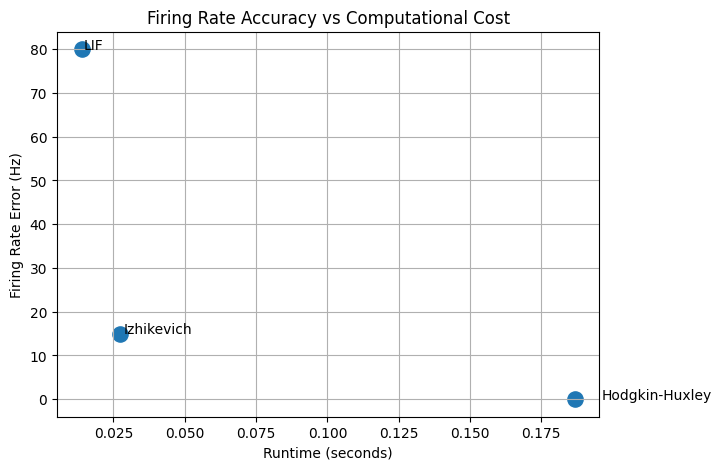

In [106]:
plt.figure(figsize=(7, 5))
plt.scatter(runtime, firing_rate_error, s=120)

for i, model in enumerate(models):
    plt.text(runtime[i]*1.05, firing_rate_error[i], model)

plt.xlabel("Runtime (seconds)")
plt.ylabel("Firing Rate Error (Hz)")
plt.title("Firing Rate Accuracy vs Computational Cost")
plt.grid(True)
plt.show()


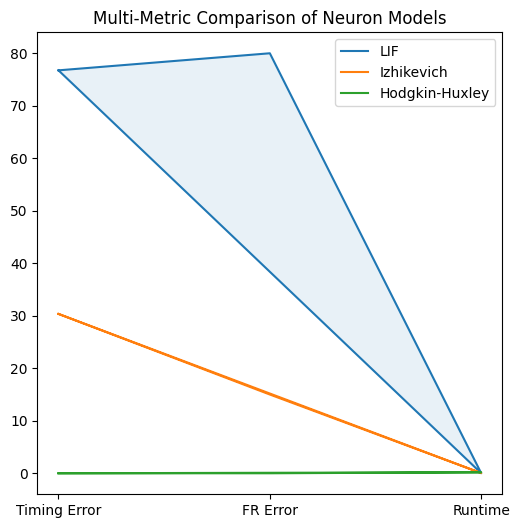

In [107]:
from math import pi

labels = ["Timing Error", "FR Error", "Runtime"]
lif_vals = [timing_err_lif, fr_error_lif, time_lif]
izh_vals = [timing_err_izh, fr_error_izh, time_izh]
hh_vals  = [0, 0, time_hh]

angles = np.linspace(0, 2*pi, len(labels), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

def radar_plot(values, label):
    values = values + [values[0]]
    plt.plot(angles, values, label=label)
    plt.fill(angles, values, alpha=0.1)

plt.figure(figsize=(6, 6))
radar_plot(lif_vals, "LIF")
radar_plot(izh_vals, "Izhikevich")
radar_plot(hh_vals, "Hodgkin-Huxley")

plt.xticks(angles[:-1], labels)
plt.title("Multi-Metric Comparison of Neuron Models")
plt.legend(loc="upper right")
plt.show()
